<a href="https://www.kaggle.com/code/ellenwang123/gtsrb-cnn-test-accuracy-99?scriptVersionId=135807166" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.utils import to_categorical
import os
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Reshape, Activation, Dot
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, LayerNormalization, Normalization
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Define dataset path

## Define ImageDataGenerator class for image augmentation

In [3]:
train_folder = '/kaggle/input/gtsrb-german-traffic-sign/Train'
test_folder = '/kaggle/input/gtsrb-german-traffic-sign'

train_datagen = ImageDataGenerator(
    validation_split = 0.3,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False,
    vertical_flip=False
)
test_datagen = ImageDataGenerator()

In [4]:
# Label Overview
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
}

## Define image size and set seed for reproducibility

In [5]:
num_classes = len(classes)
target_size_x = 48
target_size_y = 48
seed = 123
batch_size = 32
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
import pandas as pd
df = pd.read_csv(test_folder + '/Test.csv')
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


## Load traing set and converts the class vector (integers) to binary class matrix

In [7]:
x_train = []
y_train = []

for i in tqdm(range(len(classes))):         
    for imgFile in os.listdir(os.path.join(train_folder, str(i))):
        img_path = os.path.join(os.path.join(train_folder, str(i)), imgFile)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (target_size_x,target_size_y))

        x_train.append(image/255.0)
        y_train.append(i)

100%|██████████| 43/43 [03:24<00:00,  4.75s/it]


In [8]:
x_train = np.array(x_train, dtype = 'float32')
y_train = np.array(y_train, dtype = 'int32')
y_train = keras.utils.to_categorical(y_train, num_classes=43)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
print("x_train.shape", x_train.shape)
print("x_valid.shape", x_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

x_train.shape (31367, 48, 48, 3)
x_valid.shape (7842, 48, 48, 3)
y_train.shape (31367, 43)
y_valid.shape (7842, 43)


In [9]:
train_flow = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
val_flow = test_datagen.flow(
    x_val, y_val,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

## Local Contrast Normalisation

In [10]:
class LRN2D(tf.keras.layers.Layer):
    """
    Local Contrast Normalisation
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__()
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = X.shape
        half_n = self.n // 2
        input_sqr = T.sqr(X)
        extra_channels = T.alloc(0., b, ch + 2*half_n, r, c)
        input_sqr = T.set_subtensor(extra_channels[:, half_n:half_n+ch, :, :], input_sqr)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        return {"name": self.__class__.__name__,
                "alpha": self.alpha,
                "k": self.k,
                "beta": self.beta,
                "n": self.n}

## Define a compact CNN model

In [11]:
def creat_cnn_model():
    inputs = layers.Input((target_size_x, target_size_y, 3))
    
    norm = Normalization(mean=[0.4914, 0.4822, 0.4465], 
                  variance=[np.square(0.247), 
                            np.square(0.243), 
                            np.square(0.261)])(inputs)
    
    x = Conv2D(filters=200, kernel_size=(7,7), padding='valid', activation='relu', kernel_initializer="he_normal")(norm)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = LRN2D()(x)
    x = Dropout(rate=0.25)(x)
    
    x = Conv2D(filters=250, kernel_size=(4,4), padding='valid', activation='relu', kernel_initializer="he_normal")(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = LRN2D()(x)
    x = Dropout(rate=0.25)(x)
    
    x = Conv2D(filters=350, kernel_size=(4,4), padding='valid', activation='relu', kernel_initializer="he_normal")(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = LRN2D()(x)
    x = Dropout(rate=0.25)(x)
    
    x = Flatten()(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    classifier = Dense(43, activation='softmax')(x)
    return keras.Model(inputs=inputs, outputs=classifier)

In [12]:
model = creat_cnn_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 48, 48, 3)        0         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 42, 42, 200)       29600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 200)      0         
 )                                                               
                                                                 
 lrn2d (LRN2D)               (None, 21, 21, 200)       0         
                                                                 
 dropout (Dropout)           (None, 21, 21, 200)       0     

## Define class for cosinedecay learning rate

In [13]:
class CosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, min_lr, max_lr, warmup_steps=4000, alpha=0):
        super(CosineDecay, self).__init__()

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
        self.max_steps = warmup_steps * 10
        self.alpha = alpha

    def __call__(self, step):
        arg1 = (self.max_lr - self.min_lr) * step / self.warmup_steps + self.min_lr
        min_step = tf.math.minimum(step, self.max_steps)
        cosine_decay = 0.5 * (1 + tf.math.cos(np.pi * min_step / self.max_steps))
        decayed = (1 - self.alpha) * cosine_decay + self.alpha
        arg2 = (self.max_lr - self.min_lr) * decayed + self.min_lr
        return tf.math.minimum(arg1, arg2)
    
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print("\nEpoch %05d: Current learning rate is %6.4f." % (epoch, lr))

## Training the model

In [14]:
epochs = 30   # number of all epochs in training
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
batches = int(len(x_train) / batch_size)  # number of training batch to run per epoch

warmup_steps = batches * 5
learning_rate = CosineDecay(
    min_lr=1E-5, max_lr=1E-2, warmup_steps=warmup_steps
)
    
checkpoint = ModelCheckpoint(
      filepath='cnn48-{epoch:02d}-{val_acc:.4f}.h5',
      save_weights_only=True,
      monitor='val_acc',
      mode='max',
      save_best_only=True,
      initial_value_threshold=0.995)

earlystop = EarlyStopping(
      monitor='val_loss', patience=stop_patience, mode='min', restore_best_weights=True)

loss_fn = tf.keras.losses.CategoricalCrossentropy()

optimizer = keras.optimizers.SGD(learning_rate=0.02)


model.compile(
        optimizer, loss=loss_fn,
        metrics=[
        keras.metrics.CategoricalAccuracy(name="acc"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = model.fit(
    x = train_flow,
    batch_size=batch_size,
    validation_data=val_flow,
    steps_per_epoch=batches,
    verbose=1,
    epochs=epochs,
    callbacks=[checkpoint, earlystop],
    validation_steps= None,
    shuffle= False,
)

Epoch 1/30


2023-07-05 12:06:30.417068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


980/980 [==============================] - 43s 35ms/step - loss: 2.4766 - acc: 0.3262 - top-5-accuracy: 0.6496 - val_loss: 1.1794 - val_acc: 0.6227 - val_top-5-accuracy: 0.9263
Epoch 2/30
980/980 [==============================] - 34s 35ms/step - loss: 1.2228 - acc: 0.6134 - top-5-accuracy: 0.9107 - val_loss: 0.3857 - val_acc: 0.8813 - val_top-5-accuracy: 0.9949
Epoch 3/30
980/980 [==============================] - 34s 35ms/step - loss: 0.6981 - acc: 0.7761 - top-5-accuracy: 0.9695 - val_loss: 0.1795 - val_acc: 0.9616 - val_top-5-accuracy: 0.9983
Epoch 4/30
980/980 [==============================] - 34s 35ms/step - loss: 0.4468 - acc: 0.8598 - top-5-accuracy: 0.9849 - val_loss: 0.0693 - val_acc: 0.9821 - val_top-5-accuracy: 0.9996
Epoch 5/30
980/980 [==============================] - 34s 35ms/step - loss: 0.3298 - acc: 0.8972 - top-5-accuracy: 0.9905 - val_loss: 0.0384 - val_acc: 0.9917 - val_top-5-accuracy: 0.9999
Epoch 6/30
980/980 [==============================] - 34s 35ms/step - l

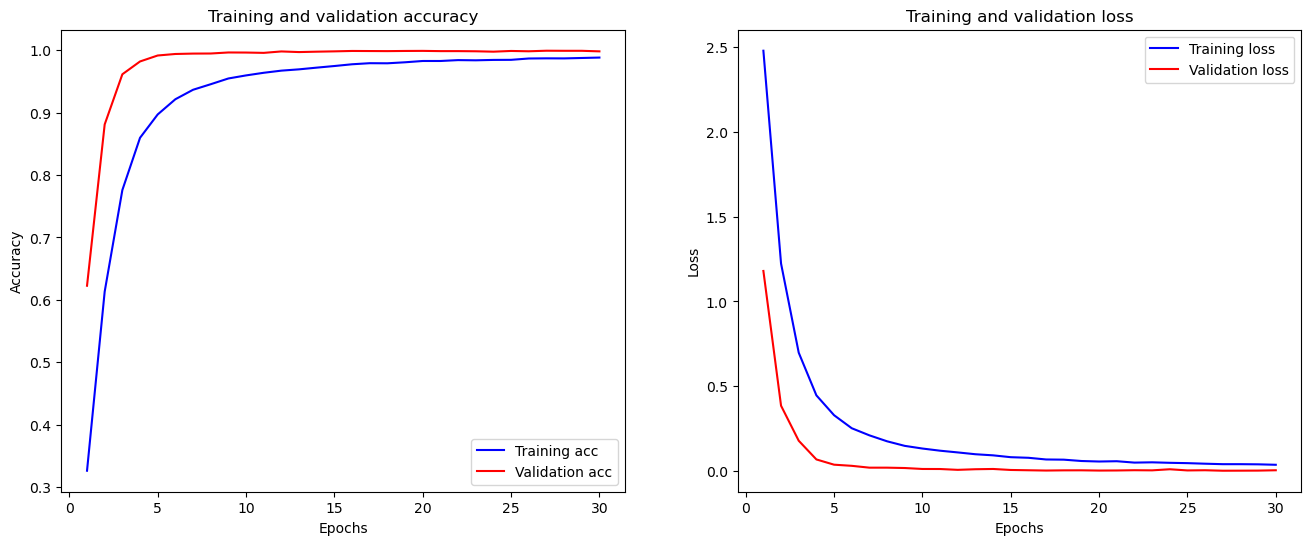

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1,2,figsize = (16,6))
axs[0].plot(epochs, acc, 'b', label='Training acc')
axs[0].plot(epochs, val_acc, 'r', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(epochs, loss, 'b', label='Training loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

In [16]:
labels = df["ClassId"].values
imgs = df["Path"].values

x_test = []

for img in tqdm(imgs):
    try:
        image = cv2.imread(test_folder + '/' +img)
        image = cv2.resize(image, (target_size_x,target_size_y))

        x_test.append(image/255.0)
    except:
        print("Error in " + img)
        
x_test = np.array(x_test, dtype = 'float32')
y_test = keras.utils.to_categorical(labels, num_classes=43)

100%|██████████| 12630/12630 [01:15<00:00, 167.61it/s]


## Evaluate

In [17]:
y_pred = model.predict(x_test)
test_result = model.evaluate(x_test, y_test)

print("Test loss : ", test_result[0])
print("Test accuracy :", test_result[1]*100, "%")

395/395 [==============================] - 3s 7ms/step - loss: 0.0663 - acc: 0.9840 - top-5-accuracy: 0.9981
Test loss :  0.06629839539527893
Test accuracy : 98.40063452720642 %
